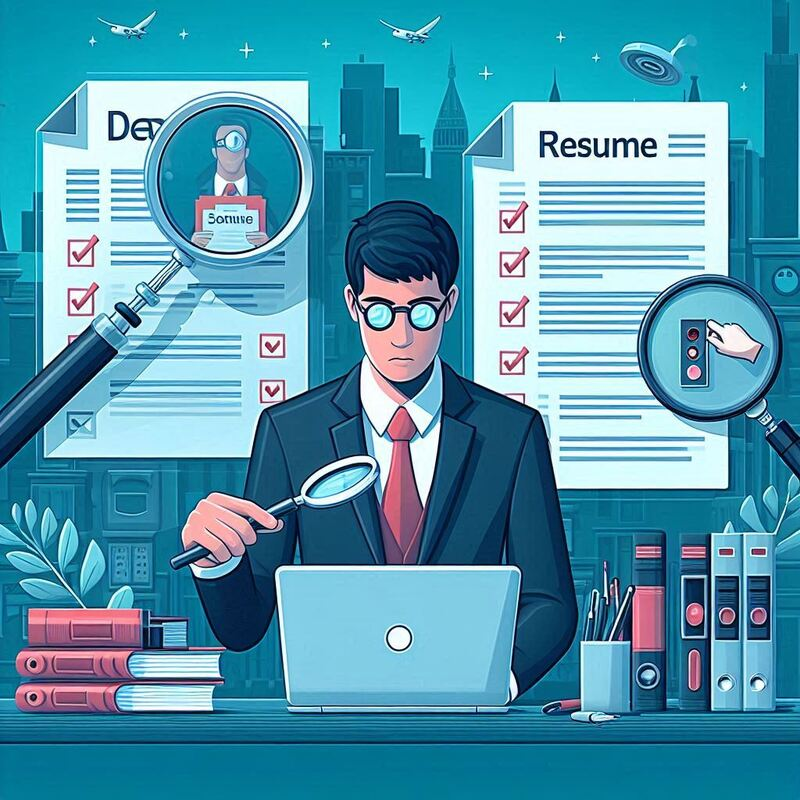

**Automated Resume Filtering Using Machine Learning and NLP**

🚀 Introduction:
The traditional manual resume review is time-consuming and prone to errors. This project aims to replace it with an automated system, saving time and improving accuracy.

🎯 Objective:
Develop an automated system using advanced ML and NLP techniques to filter resumes based on job descriptions efficiently.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🐸 Install Libraries

In [1]:
# Install required packages
! pip install pypdf2  # For working with PDF files
! pip install pyresparser  # For parsing resumes
! pip install spacy==2.3.5  # Specific version of spaCy required by pyresparser
! pip install nltk  # Natural Language Toolkit
! pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz  # English language model for spaCy


  Using cached spacy-2.3.5.tar.gz (5.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for spacy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for spacy
Failed to build spacy
ERROR: Could not build wheels for spacy, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 71.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


📌 note: **about resumeparser**

Pyresparser is a concise resume parser in Python, adept at swiftly extracting vital information from resumes. Its key features include extracting name, email, and mobile numbers, as well as discerning skills, total experience, college names, degrees, designations, and company names.

https://omkarpathak.in/pyresparser/



# 🌀 Import Libraries

In [3]:
import pandas as pd
#import base64, random
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import spacy
from spacy import glossary
import pyresparser
import os
from pyresparser import ResumeParser
from PyPDF2 import PdfReader

#from pdfminer3.layout import LAParams, LTTextBox
#from pdfminer3.pdfpage import PDFPage
#from pdfminer3.pdfinterp import PDFResourceManager
#from pdfminer3.pdfinterp import PDFPageInterpreter
#from pdfminer3.converter import TextConverter

#import io, random
import re
from nltk.corpus import stopwords
import string  # Import the string module to access punctuation characters


from nltk.util import ngrams
# Restore default warning settings
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities, matutils

# Suppress specific warnings
warnings.filterwarnings("ignore", message=".*find_spec\(\) not found; falling back to find_module\(\)", category=ImportWarning)
warnings.filterwarnings("ignore", message=".*requires spaCy v2.1 and is incompatible with the current spaCy version.*", category=UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 📕 Data Preprocessing and EDA

### Parse PDF Resumes with Pyresparser

In [4]:
def parse_resumes_in_directory(directory):
    """
    Parses all PDF resumes in the given directory using pyresparser.

    Parameters:
    - directory (str): Path to the directory containing PDF resumes.

    Returns:
    - list: A list of dictionaries, where each dictionary contains the extracted data from one PDF file.
    """
    # List all PDF files in the directory
    pdf_files = [file for file in os.listdir(directory) if file.endswith('.pdf')]

    # Initialize an empty list to store extracted data
    all_data = []

    # Loop through each PDF file and parse it
    for pdf_file in pdf_files:
        # Construct the full path to the PDF file
        pdf_path = os.path.join(directory, pdf_file)

        # Parse the PDF file and extract data
        data = ResumeParser(pdf_path).get_extracted_data()

        # Append the extracted data to the list
        all_data.append(data)

    return all_data

# Example directory containing PDF resumes
directory = '/content/drive/MyDrive/AI Project/resume-filttering/Dataset/Resumes'

# Call the function to parse resumes in the directory
all_data = parse_resumes_in_directory(directory)


# Print the extracted data
for data in all_data:
    print(data)



# Extract keys from the first dictionary to ensure consistent columns
keys = all_data[0].keys()

# Check if all dictionaries have the same keys
if all(d.keys() == keys for d in all_data):
    # Create DataFrame
    df = pd.DataFrame(all_data)
    # Transpose DataFrame
    df = df.T
    # Set the first row as the column headers
    df.columns = df.iloc[0]
    # Remove the first row (it's now the column headers)
    df = df[1:]
    print(df)
else:
    print("All dictionaries must have the same keys.")



# Dataframe Output after Transpose
df = df.T

#Dataframe
df.head(5)

{'name': 'Barry Allen', 'email': 'allthe.stars@google.com', 'mobile_number': '456-7890', 'skills': ['Engineering', 'Design', 'Docker', 'Html5', 'Javascript', 'Ux', 'Apis', 'Babel', 'Computer science', 'Cloud', 'Python', 'Agile', 'Ui', 'Vue.js'], 'college_name': None, 'degree': None, 'designation': None, 'experience': ['June 2022 –', 'Present', 'Software Engineer (Front-End), Google, Mountain View, CA, USA', 'Developing intuitive and engaging user interfaces using React and Redux. Working closely', 'with UX designers to implement responsive and accessible web design. Participating in', 'agile development processes, including sprint planning and code reviews. Collaborating with', 'back-end developers to integrate RESTful APIs and ensure seamless data flow.'], 'company_names': None, 'no_of_pages': 1, 'total_experience': 0.0}
{'name': 'Bruce Wayne', 'email': 'bwayne@email.com', 'mobile_number': '456-7890', 'skills': ['System', 'Javascript', 'User experience', 'Facebook', 'Ai', 'Coding', 'D

email mobile_number  \
name                                                           
Barry Allen            allthe.stars@google.com      456-7890   
Bruce Wayne                   bwayne@email.com      456-7890   
Alfred Pennyworth  alfred.pennyworth@email.com      456-7890   
Harvey Dent                    hdent@email.com      456-7891   
JOHN DOE                    john.doe@email.com      456-7890   

                                                              skills  \
name                                                                   
Barry Allen        [Engineering, Design, Docker, Html5, Javascrip...   
Bruce Wayne        [System, Javascript, User experience, Facebook...   
Alfred Pennyworth  [Research, Sql, System, Automation, Javascript...   
Harvey Dent        [Research, Sql, Training, Pytorch, Facebook, S...   
JOHN DOE           [Sql, System, Html5, Javascript, User experien...   

                  college_name  \
name                             
Barry Allen               None   
Bruce Wayne               None   
Alfred Pennyworth         None   
Harvey Dent               None   
JOHN DOE                  None   

                                                              degree  \
name                                                                   
Barry Allen                                                     None   
Bruce Wayne                [Bachelor of Science in Computer Science]   
Alfred Pennyworth                                               None   
Harvey Dent                [Bachelor of Science in Computer Science]   
JOHN DOE           [Bachelor of Science in Computer Science, Stat...   

                                   designation  \
name                                             
Barry Allen                               None   
Bruce Wayne                               None   
Alfred Pennyworth                         None   
Harvey Dent        [Machine Learning Engineer]   
JOHN DOE                                  None   

                                                          experience  \
name                                                                   
Barry Allen        [June 2022 –, Present, Software Engineer (Fron...   
Bruce Wayne        [June 2020 –, Present, July 2015 –, May 2020, ...   
Alfred Pennyworth  [meet business goals., 2012 – 2017 Software De...   
Harvey Dent        [2021 –, Present, Machine Learning Engineer, O...   
JOHN DOE           [by 30, • Integrated applications with MySQL a...   

                  company_names no_of_pages total_experience  
name                                                          
Barry Allen                None           1              0.0  
Bruce Wayne                None           2              0.0  
Alfred Pennyworth          None           2              0.0  
Harvey Dent                None           1              0.0  
JOHN DOE                   None           2             1.92

# 🐱 PDF Resumes and Organize Details into DataFrame

In [5]:
# Directory containing PDF files
directory = "/content/drive/MyDrive/AI Project/resume-filttering/Dataset/Resumes"

def resume_parsing(directory):
    # List to store resume details dictionaries
    resume_details_list = []

    # Iterate over files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".pdf"):
            filepath = os.path.join(directory, filename)

            # Open the PDF file
            with open(filepath, "rb") as file:
                # Create PdfReader object
                reader = PdfReader(file)
                # Get number of pages in the PDF
                number_of_pages = len(reader.pages)

                # Iterate over pages
                for i, page in enumerate(reader.pages):
                    # Extract text from the page
                    text = page.extract_text()

                    # Store resume details in a dictionary
                    resume_details = {
                        "Filename": filename,
                        "Page": i+1,
                        "Text": text
                    }

                    # Append dictionary to the list
                    resume_details_list.append(resume_details)

    # Create DataFrame from the list
    df_resume = pd.DataFrame(resume_details_list)
    return df_resume

# Call the function to parse resumes and store the result in a DataFrame
df_resume = resume_parsing(directory)

# Display the DataFrame
df_resume


Filename  Page  \
0         barry_allen_fe.pdf     1   
1  bruce_wayne_fullstack.pdf     1   
2  bruce_wayne_fullstack.pdf     2   
3   alfred_pennyworth_pm.pdf     1   
4   alfred_pennyworth_pm.pdf     2   
5        harvey_dent_mle.pdf     1   
6               john_doe.pdf     1   
7               john_doe.pdf     2   

                                                Text  
0  Barry Allen\nFront-End DeveloperGoogle HQ, Mou...  
1  Bruce Wayne\nMERN Stack Developer123 Gotham St...  
2  Projects\n2019 –\nPresentPersonal Project: Got...  
3  Alfred Pennyworth\nProduct ManagerSilicon Vall...  
4  2020 –\nPresentPersonal Project: Home Automati...  
5  Harvey Dent\nMachine Learning Engineer321 Goth...  
6  JOHN DOE\n123 Main St, Anywhere, USA — (123) 4...  
7  EDUCATION\nBachelor of Science in Computer Sci...

In [6]:


# Group by Filename
grouped_resume = df_resume.groupby('Filename')

# Concatenate rows and ensure Page 1 and 2 are not repetitive using list comprehension
result_resume = [{'Filename': filename,
                  'no_of_pages': group['Page'].max(),
                  'Text': (group[group['Page'] == 1]['Text'].iloc[0] + ' ' + group[group['Page'] == 2]['Text'].iloc[0])
                          if len(group[group['Page'] == 1]) > 0 and len(group[group['Page'] == 2]) > 0
                          and group[group['Page'] == 1]['Text'].iloc[0] != group[group['Page'] == 2]['Text'].iloc[0]
                          else group[group['Page'] == 1]['Text'].iloc[0]} for filename, group in grouped_resume]

# Create DataFrame from the result list
result_df_resume = pd.DataFrame(result_resume)

#Name Extraction
def extract_name(text):
    return text.split('\n')[0]

# Add Name column
result_df_resume['name'] = result_df_resume['Text'].apply(extract_name)


# Function to extract job titles
def extract_job_title(text):
    post_text = text.split('\n')[1]  # Take the part after the first '\n'
    post = post_text.split(',')[0]   # Take the part before the first ','
    words = [word for word in post.split() if word[0].isupper()]  # Select words starting with uppercase letters
    # Select up to the first three uppercase words
    words = words[:3]
    # Remove words containing digits
    words = [word for word in words if not any(char.isdigit() for char in word)]
    if 1 <= len(words) <= 3:
        return ' '.join(words)
    return None

# Apply the function to 'Text' column
result_df_resume['current_post'] = result_df_resume['Text'].apply(extract_job_title)


# Regular expression pattern to extract experience year
experience_pattern = r"(\d+)\+? ?(?:Years?|Yrs|years?)\s"

# Function to extract experience year
def extract_experience(row):
    experience_years = re.search(experience_pattern, row["Text"])
    return experience_years.group(1) if experience_years else None

# Apply the function to each row to create the new column
result_df_resume["Total_experience"] = result_df_resume.apply(extract_experience, axis=1).fillna(0).astype(int)


# Load English language model
nlp = spacy.load("en_core_web_sm")
# Split each name into its individual components and convert them into a list
name_lists = result_df_resume['name'].str.split().explode().tolist()

def extract_keywords(dataset, column_name):
    #text = dataset[column_name]
    # Check if the value in the column is already a string
    if isinstance(dataset[column_name], str):
        text = dataset[column_name]
    else:
        text = ' '.join(dataset[column_name])  # Convert list to string

    doc = nlp(text)
    pos_tag_tokens = [(tok, tok.tag_) for tok in doc]
    keywords = [str(t[0]) for t in pos_tag_tokens if t[1] in ['NNP', 'NN'] and not t[0].is_digit]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in keywords if word.lower() not in stop_words]
    # Split each name into its individual components and convert them into a list
    #name_list = row['name'].split() if isinstance(row['name'], str) else []

    # Remove specific words
    filtered_tokens = [word for word in filtered_tokens if word not in name_lists]

    return filtered_tokens

# Apply the function to each row to create the new column
#result_df_resume["Keywords"] = result_df_resume.apply, axis=1)
result_df_resume['Keywords'] = result_df_resume.apply(extract_keywords, column_name='Text', axis=1)

result_df_resume






Filename  no_of_pages  \
0   alfred_pennyworth_pm.pdf            2   
1         barry_allen_fe.pdf            1   
2  bruce_wayne_fullstack.pdf            2   
3        harvey_dent_mle.pdf            1   
4               john_doe.pdf            2   

                                                Text               name  \
0  Alfred Pennyworth\nProduct ManagerSilicon Vall...  Alfred Pennyworth   
1  Barry Allen\nFront-End DeveloperGoogle HQ, Mou...        Barry Allen   
2  Bruce Wayne\nMERN Stack Developer123 Gotham St...        Bruce Wayne   
3  Harvey Dent\nMachine Learning Engineer321 Goth...        Harvey Dent   
4  JOHN DOE\n123 Main St, Anywhere, USA — (123) 4...           JOHN DOE   

                    current_post  Total_experience  \
0  Product ManagerSilicon Valley                20   
1   Front-End DeveloperGoogle HQ                 0   
2                     MERN Stack                10   
3               Machine Learning                 5   
4                        Main St                 5   

                                            Keywords  
0  [Product, ManagerSilicon, Valley, CA, USA, ina...  
1  [End, DeveloperGoogle, HQ, Mountain, View, CA,...  
2  [MERN, Stack, Developer123, Gotham, St, Gotham...  
3  [Machine, Learning, Engineer321, Gotham, St, G...  
4  [Main, St, Anywhere, USA, LinkedIn, GitHub, SU...

### 🐻 Prepare Dataframe for Resume

In [7]:
# Merge the two DataFrames on the 'Name' column and replace 'total_experience' with 'Total PDF pages'
df_final = df.copy()
df_final = df_final.merge(result_df_resume[['name', 'current_post', 'Total_experience', 'Keywords']], on='name', how='left')
#df['total_experience'] = df['total_experience']

# Assuming your DataFrame is named df
df_final['designation'] = df_final['designation'].fillna(df_final['current_post'])

# Drop unnecessary columns
df_final.drop(columns=['total_experience', 'college_name', 'degree', 'company_names', 'current_post'], inplace=True)

# Apply the function to each row to create the new column
df_final["experience"] = df_final.apply(extract_keywords, column_name='experience', axis=1)
#df_final['experience'] = df_final.apply(extract_experience, column_name='experience', axis=1)

# Combine skills and experience columns and remove duplicates
df_final['skills_and_experience'] = df_final.apply(lambda row: list(set(row['skills'] + row['experience'])), axis=1)

# Remove duplicates within each list in the 'skills_and_experience' column
df_final['skills_and_experience'] = df_final['skills_and_experience'].apply(lambda x: list(set(x)))


#display dataframe
df_final



name                        email mobile_number  \
0        Barry Allen      allthe.stars@google.com      456-7890   
1        Bruce Wayne             bwayne@email.com      456-7890   
2  Alfred Pennyworth  alfred.pennyworth@email.com      456-7890   
3        Harvey Dent              hdent@email.com      456-7891   
4           JOHN DOE           john.doe@email.com      456-7890   

                                              skills  \
0  [Engineering, Design, Docker, Html5, Javascrip...   
1  [System, Javascript, User experience, Facebook...   
2  [Research, Sql, System, Automation, Javascript...   
3  [Research, Sql, Training, Pytorch, Facebook, S...   
4  [Sql, System, Html5, Javascript, User experien...   

                     designation  \
0   Front-End DeveloperGoogle HQ   
1                     MERN Stack   
2  Product ManagerSilicon Valley   
3    [Machine Learning Engineer]   
4                        Main St   

                                          experience no_of_pages  \
0  [June, Present, Software, Engineer, Front, End...           1   
1  [June, Present, July, May, June, June, MERN, S...           2   
2  [business, Software, Development, Engineer, II...           2   
3  [Present, Machine, Learning, Engineer, OpenAI,...           1   
4  [•, MySQL, MongoDB, Agile, development, team, ...           2   

   Total_experience                                           Keywords  \
0                 0  [End, DeveloperGoogle, HQ, Mountain, View, CA,...   
1                10  [MERN, Stack, Developer123, Gotham, St, Gotham...   
2                20  [Product, ManagerSilicon, Valley, CA, USA, ina...   
3                 5  [Machine, Learning, Engineer321, Gotham, St, G...   
4                 5  [Main, St, Anywhere, USA, LinkedIn, GitHub, SU...   

                               skills_and_experience  
0  [Design, View, Javascript, Present, UX, CA, sp...  
1  [Design, legacy, Architecture, Javascript, Cod...  
2  [Design, Development, Javascript, commerce, Co...  
3  [research, R., training, Nosql, Present, Pytor...  
4  [Mysql, Javascript, XYZ, Nosql, system, party,...

### 😆 Visiual Representation of Word Cloud of different CV

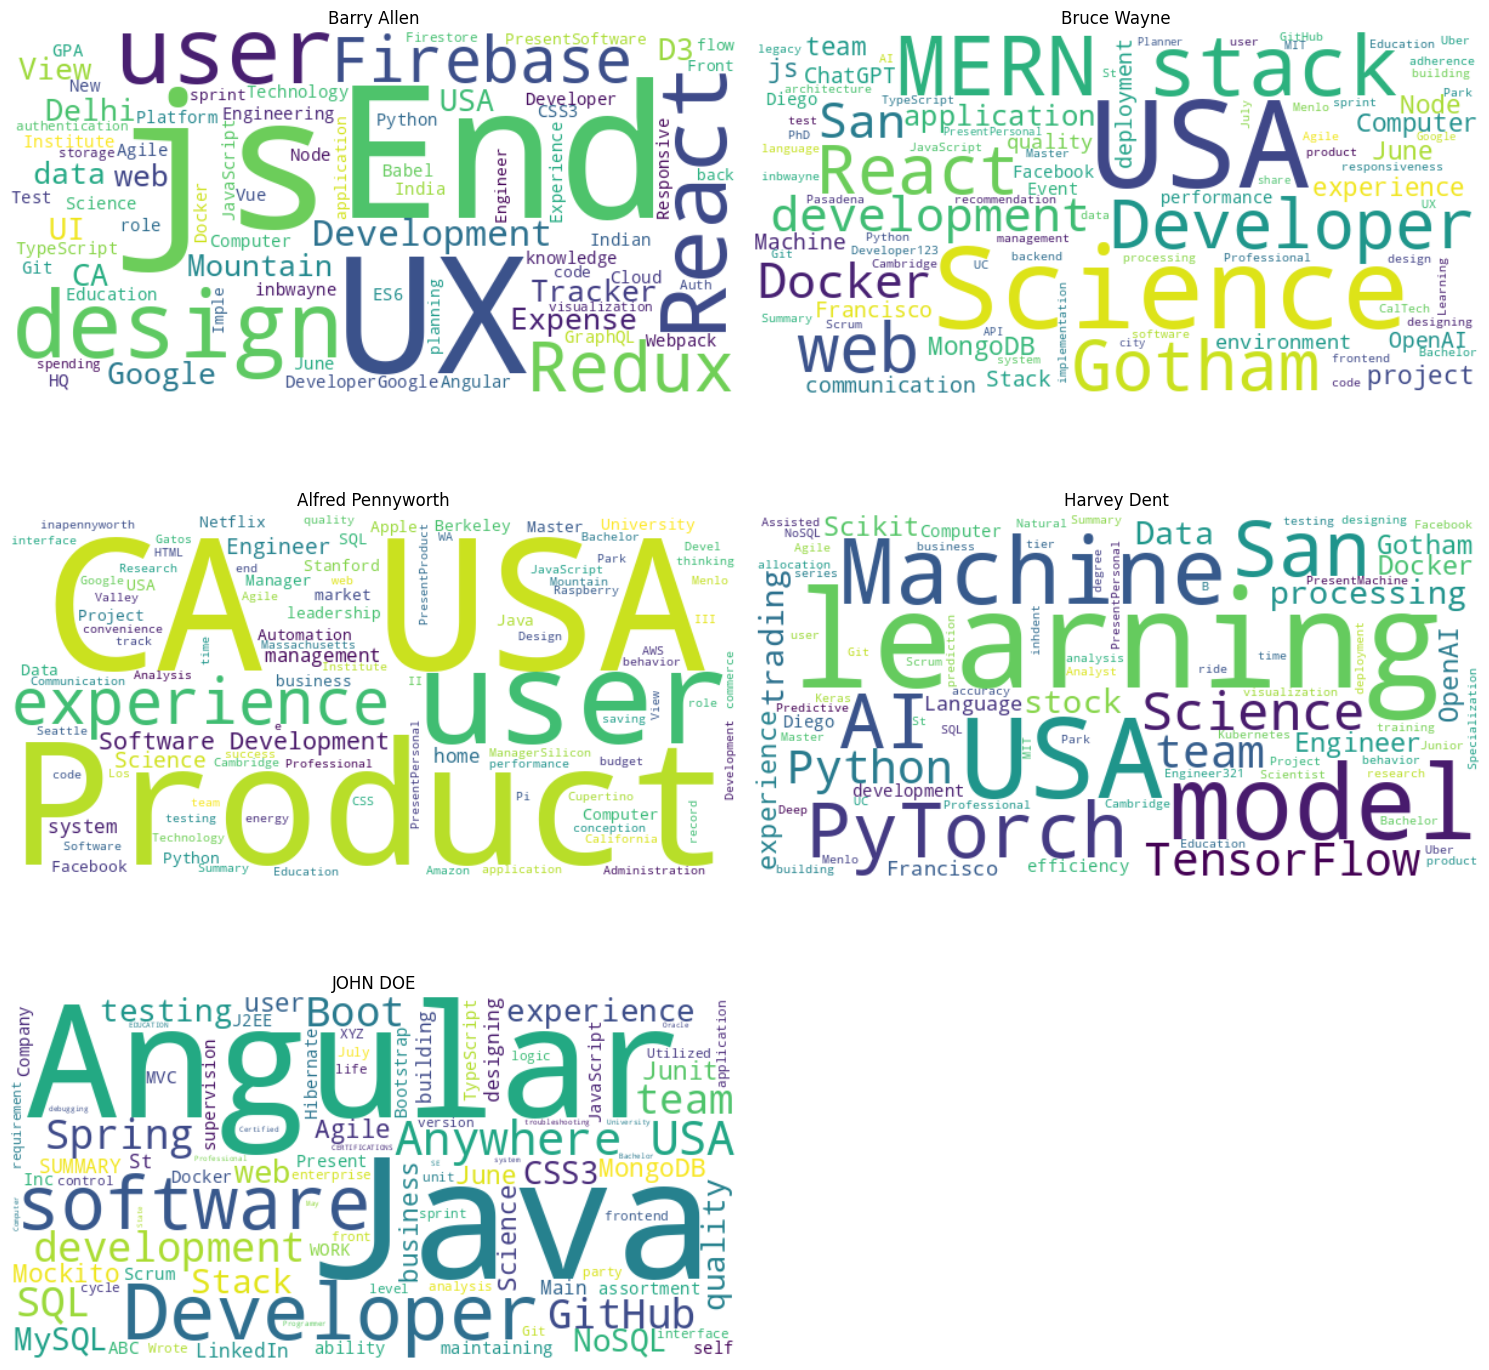

In [ ]:
# Function to generate word cloud without frequency for each category
def generate_wordclouds_by_category(df):
    # Get unique categories
    categories = df['name'].unique()

    # Create subplots
    num_categories = len(categories)
    num_plots_per_row = 2
    num_rows = (num_categories + num_plots_per_row - 1) // num_plots_per_row
    fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    # Iterate through categories
    for i, category in enumerate(categories):
        # Filter DataFrame for the current category
        category_df = df[df['name'] == category]

        # Flatten the list of lists into a single list of strings
        all_keywords = [keyword for sublist in category_df['Keywords'] for keyword in sublist]

        # Joining keywords into a single string
        wordcloud_text = ' '.join(all_keywords)

        # Generating the word cloud
        wordcloud = WordCloud(width=600, height=300, background_color='white').generate(wordcloud_text)

        # Displaying the word cloud in the corresponding subplot
        ax = axes[i]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(category)
        ax.axis('off')

    # Remove empty subplots
    for j in range(num_categories, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function to generate word clouds for each category
generate_wordclouds_by_category(df_final)

In [12]:
df_final

name                        email mobile_number  \
0        Barry Allen      allthe.stars@google.com      456-7890   
1        Bruce Wayne             bwayne@email.com      456-7890   
2  Alfred Pennyworth  alfred.pennyworth@email.com      456-7890   
3        Harvey Dent              hdent@email.com      456-7891   
4           JOHN DOE           john.doe@email.com      456-7890   

                                              skills  \
0  [Engineering, Design, Docker, Html5, Javascrip...   
1  [System, Javascript, User experience, Facebook...   
2  [Research, Sql, System, Automation, Javascript...   
3  [Research, Sql, Training, Pytorch, Facebook, S...   
4  [Sql, System, Html5, Javascript, User experien...   

                     designation  \
0   Front-End DeveloperGoogle HQ   
1                     MERN Stack   
2  Product ManagerSilicon Valley   
3    [Machine Learning Engineer]   
4                        Main St   

                                          experience no_of_pages  \
0  [June, Present, Software, Engineer, Front, End...           1   
1  [June, Present, July, May, June, June, MERN, S...           2   
2  [business, Software, Development, Engineer, II...           2   
3  [Present, Machine, Learning, Engineer, OpenAI,...           1   
4  [•, MySQL, MongoDB, Agile, development, team, ...           2   

   Total_experience                                           Keywords  \
0                 0  [End, DeveloperGoogle, HQ, Mountain, View, CA,...   
1                10  [MERN, Stack, Developer123, Gotham, St, Gotham...   
2                20  [Product, ManagerSilicon, Valley, CA, USA, ina...   
3                 5  [Machine, Learning, Engineer321, Gotham, St, G...   
4                 5  [Main, St, Anywhere, USA, LinkedIn, GitHub, SU...   

                               skills_and_experience  
0  [Design, View, Javascript, Present, UX, CA, sp...  
1  [Design, legacy, Architecture, Javascript, Cod...  
2  [Design, Development, Javascript, commerce, Co...  
3  [research, R., training, Nosql, Present, Pytor...  
4  [Mysql, Javascript, XYZ, Nosql, system, party,...

### 🐨 name vs email

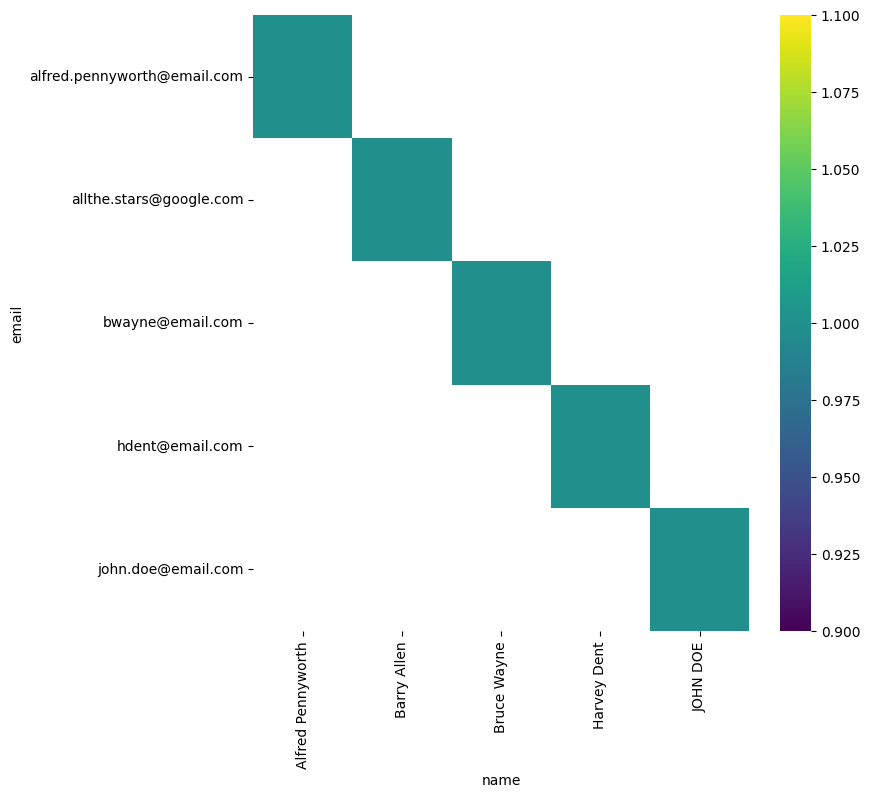

In [19]:

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['email'].value_counts()
    for x_label, grp in df_final.groupby('name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('name')
plt.ylabel('email')
plt.show()

### 🐰 Comparison of Total Experience by Name and Number of Pages in Resume

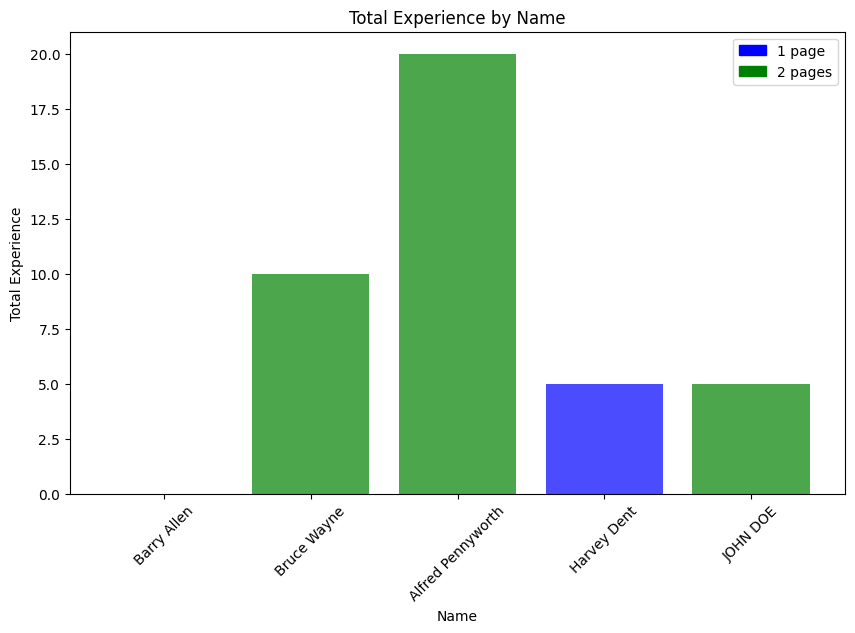

In [17]:
# Map number of pages to colors
colors = {1: 'blue', 2: 'green'}  # Map number of pages to colors

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df_final['name'], df_final['Total_experience'], color=df_final['no_of_pages'].map(colors), alpha=0.7)
plt.xlabel('Name')
plt.ylabel('Total Experience')
plt.title('Total Experience by Name')
plt.xticks(rotation=45)

# Create legend
legend_labels = {1: '1 page', 2: '2 pages'}  # Legend labels
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=color) for color in colors.values()],
           labels=legend_labels.values())

plt.show()

### 🐻 Prepare Dataframe for Job Description

In [20]:
# Directory containing PDF files
directory = "/content/drive/MyDrive/AI Project/resume-filttering/Dataset/JobDescription"

# List to store job details dictionaries
job_details_list = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".pdf"):
        filepath = os.path.join(directory, filename)

        # Open the PDF file
        with open(filepath, "rb") as file:
            # Create PdfReader object
            reader = PdfReader(file)
            # Get number of pages in the PDF
            number_of_pages = len(reader.pages)

            # Iterate over pages
            for i, page in enumerate(reader.pages):
                # Extract text from the page
                text = page.extract_text()

                # Store job details in a dictionary
                job_details = {
                    "Filename": filename,
                    "Page": i+1,
                    "Text": text
                }

                # Append dictionary to the list
                job_details_list.append(job_details)

# Create DataFrame from the list
df_job = pd.DataFrame(job_details_list)




# Group by Filename
grouped = df_job.groupby('Filename')

# Concatenate rows and ensure Page 1 and 2 are not repetitive
#result = [{'Filename': filename, 'Text': (group[group['Page'] == 1]['Text'].iloc[0] + ' ' + group[group['Page'] == 2]['Text'].iloc[0]) if group[group['Page'] == 1]['Text'].iloc[0] not in group[group['Page'] == 2]['Text'].iloc[0] else group[group['Page'] == 1]['Text'].iloc[0]} for filename, group in grouped]
# Concatenate rows and ensure Page 1 and 2 are not repetitive using list comprehension
result = [{'Filename': filename,
                  'no_of_pages': group['Page'].max(),
                  'Text': (group[group['Page'] == 1]['Text'].iloc[0] + ' ' + group[group['Page'] == 2]['Text'].iloc[0])
                          if len(group[group['Page'] == 1]) > 0 and len(group[group['Page'] == 2]) > 0
                          and group[group['Page'] == 1]['Text'].iloc[0] != group[group['Page'] == 2]['Text'].iloc[0]
                          else group[group['Page'] == 1]['Text'].iloc[0]} for filename, group in grouped]
result_df_job = pd.DataFrame(result)



# Function to extract job description
def extract_job_description(text):
    match = re.search(r'Job Description: (.*?)\(', text)
    if match:
        return match.group(1).strip()  # Removing extra spaces
    return None

# Add job_title column
result_df_job['job_title'] = result_df_job['Text'].apply(extract_job_description)

#result_df_resume["Keywords"] = result_df_resume.apply, axis=1)
result_df_job['Keywords'] = result_df_job.apply(extract_keywords, column_name='Text', axis=1)
result_df_job.drop('Text', inplace = True, axis = 1)

#display dataframe
result_df_job



Filename  no_of_pages                   job_title  \
0   job_desc_front_end_engineer.pdf            2          Front End Engineer   
1  job_desc_full_stack_engineer.pdf            2  Senior Full Stack Engineer   
2       job_desc_java_developer.pdf            2              Java Developer   
3      job_desc_product_manager.pdf            2             Product Manager   

                                            Keywords  
0  [Job, Description, End, Engineer, Experience, ...  
1  [Job, Description, Full, Stack, Engineer, Expe...  
2  [Job, Description, Java, Developer, Experience...  
3  [Job, Description, Product, Manager, Experienc...

### 😆 Visiual Representation of Word Cloud of different JD

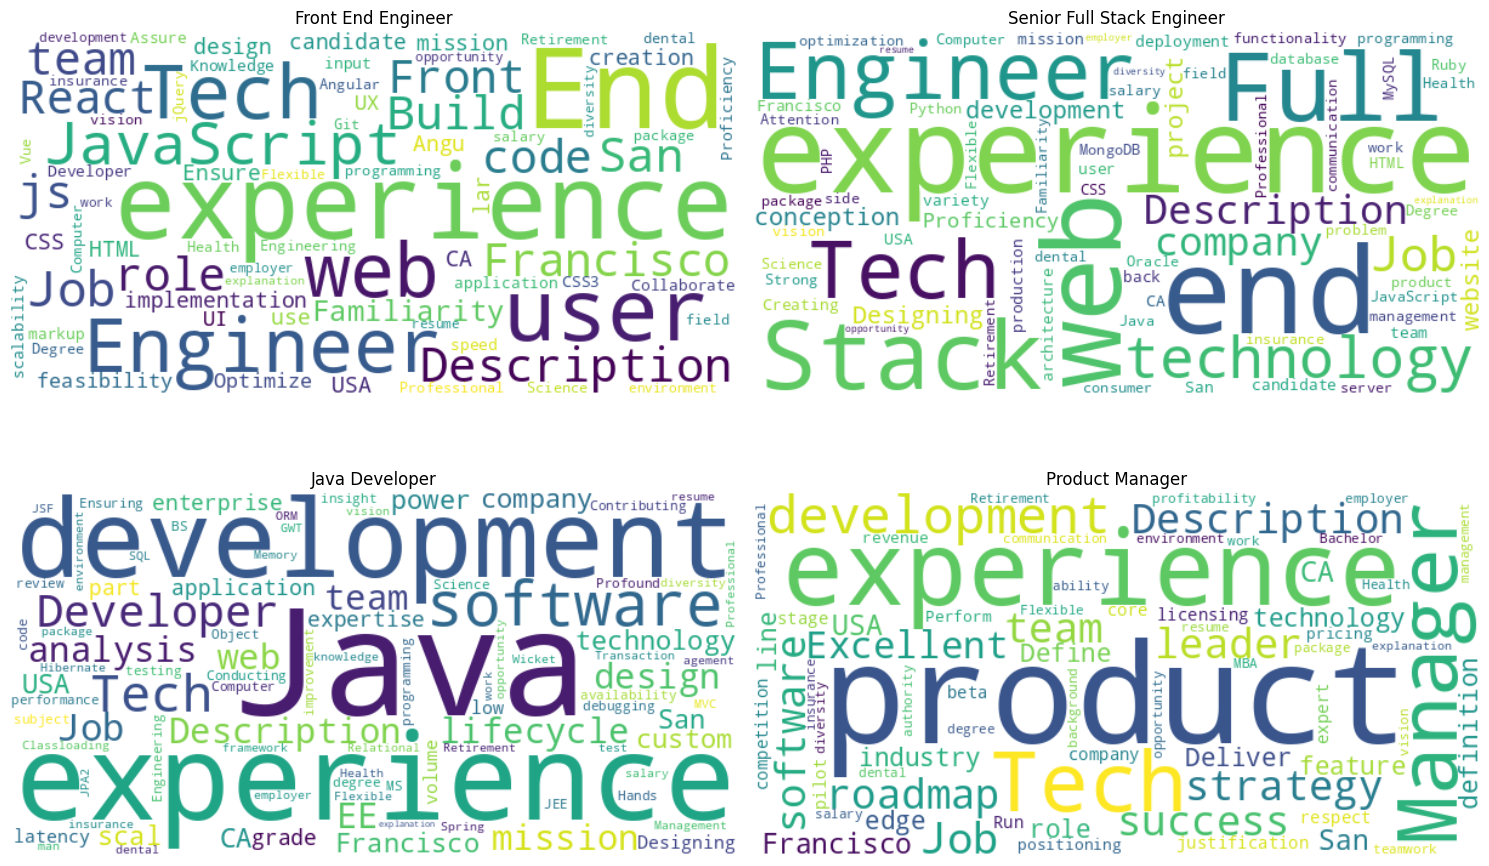

In [9]:
# Function to generate word cloud without frequency for each category
def generate_wordclouds_by_category_job_title(df):
    # Get unique categories
    categories = df['job_title'].unique()

    # Create subplots
    num_categories = len(categories)
    num_plots_per_row = 2
    num_rows = (num_categories + num_plots_per_row - 1) // num_plots_per_row
    fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    # Iterate through categories
    for i, category in enumerate(categories):
        # Filter DataFrame for the current category
        category_df = df[df['job_title'] == category]

        # Flatten the list of lists into a single list of strings
        all_keywords = [keyword for sublist in category_df['Keywords'] for keyword in sublist]

        # Joining keywords into a single string
        wordcloud_text = ' '.join(all_keywords)

        # Generating the word cloud
        wordcloud = WordCloud(width=600, height=300, background_color='white').generate(wordcloud_text)

        # Displaying the word cloud in the corresponding subplot
        ax = axes[i]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(category)
        ax.axis('off')

    # Remove empty subplots
    for j in range(num_categories, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function to generate word clouds for each category
generate_wordclouds_by_category_job_title(result_df_job)

# 🐹 Similarity Result Job Description vs Resume

In [21]:
# Diplay Job Description
result_df_job

Filename  no_of_pages                   job_title  \
0   job_desc_front_end_engineer.pdf            2          Front End Engineer   
1  job_desc_full_stack_engineer.pdf            2  Senior Full Stack Engineer   
2       job_desc_java_developer.pdf            2              Java Developer   
3      job_desc_product_manager.pdf            2             Product Manager   

                                            Keywords  
0  [Job, Description, End, Engineer, Experience, ...  
1  [Job, Description, Full, Stack, Engineer, Expe...  
2  [Job, Description, Java, Developer, Experience...  
3  [Job, Description, Product, Manager, Experienc...

In [22]:
# Display Resume
df_final

name                        email mobile_number  \
0        Barry Allen      allthe.stars@google.com      456-7890   
1        Bruce Wayne             bwayne@email.com      456-7890   
2  Alfred Pennyworth  alfred.pennyworth@email.com      456-7890   
3        Harvey Dent              hdent@email.com      456-7891   
4           JOHN DOE           john.doe@email.com      456-7890   

                                              skills  \
0  [Engineering, Design, Docker, Html5, Javascrip...   
1  [System, Javascript, User experience, Facebook...   
2  [Research, Sql, System, Automation, Javascript...   
3  [Research, Sql, Training, Pytorch, Facebook, S...   
4  [Sql, System, Html5, Javascript, User experien...   

                     designation  \
0   Front-End DeveloperGoogle HQ   
1                     MERN Stack   
2  Product ManagerSilicon Valley   
3    [Machine Learning Engineer]   
4                        Main St   

                                          experience no_of_pages  \
0  [June, Present, Software, Engineer, Front, End...           1   
1  [June, Present, July, May, June, June, MERN, S...           2   
2  [business, Software, Development, Engineer, II...           2   
3  [Present, Machine, Learning, Engineer, OpenAI,...           1   
4  [•, MySQL, MongoDB, Agile, development, team, ...           2   

   Total_experience                                           Keywords  \
0                 0  [End, DeveloperGoogle, HQ, Mountain, View, CA,...   
1                10  [MERN, Stack, Developer123, Gotham, St, Gotham...   
2                20  [Product, ManagerSilicon, Valley, CA, USA, ina...   
3                 5  [Machine, Learning, Engineer321, Gotham, St, G...   
4                 5  [Main, St, Anywhere, USA, LinkedIn, GitHub, SU...   

                               skills_and_experience  
0  [Design, View, Javascript, Present, UX, CA, sp...  
1  [Design, legacy, Architecture, Javascript, Cod...  
2  [Design, Development, Javascript, commerce, Co...  
3  [research, R., training, Nosql, Present, Pytor...  
4  [Mysql, Javascript, XYZ, Nosql, system, party,...

# 👻 Cosine Similarities Between JD and Resume

Cosine similarity is a measure used to determine how similar two documents are based on their word frequency. It calculates the cosine of the angle between two vectors, representing the documents in a high-dimensional space. A value closer to 1 indicates high similarity, while a value closer to 0 suggests dissimilarity.

In [46]:
# Cosine Similarity Function
def cosine_similarity_score(job_column, resume_column, job_title_col, vectorization_method, resume_dataset, name):
    # Calculate TF-IDF vectors
    vectorizer = vectorization_method

    # Job description
    result_df_job_vectorized = vectorizer.fit_transform([' '.join(doc) for doc in job_column])

    # Resume
    df_final_vectorized = vectorizer.transform([' '.join(doc) for doc in resume_column])

    # Compute cosine similarities
    cosine_similarities = cosine_similarity(result_df_job_vectorized, df_final_vectorized)

    # Convert to percentages with two decimal digits and add percentage sign
    cosine_similarities_percentage = (cosine_similarities * 100).round(2)

    print("Output of cosine_similarities (in percentage):\n", cosine_similarities_percentage)

    # Create DataFrame with similarity scores
    result_df_similarities = pd.DataFrame(cosine_similarities_percentage.T,
                                          columns=[job_title + ' Cosine_Similarity(%)' for job_title in job_title_col])

    # Resulted score
    score_result = pd.concat([resume_dataset, result_df_similarities], axis=1)
    print("cosine similarities result")
    print(result_df_similarities)

    #print("Output result using " + name + " for " + str(job_column) + " and " + str(resume_column))
    return score_result



###  

### 🎉 Apply TfIdf Vectorizer

In [47]:
# job Keywords and resume keywords
tfidf_result_1 = cosine_similarity_score(result_df_job['Keywords'], df_final['Keywords'],
                                  result_df_job['job_title'], TfidfVectorizer(),
                                  df_final[['name', 'email', 'mobile_number',
                                            'no_of_pages', 'Total_experience', 'skills_and_experience']], "TF-IDF")

print("Output result using TF-IDF for job Keywords and resume keywords")
tfidf_result_1


Output of cosine_similarities (in percentage):
 [[65.77 30.99 34.77 25.69 23.16]
 [29.34 40.96 36.34 30.74 23.1 ]
 [16.99 23.84 41.15 21.46 52.8 ]
 [ 5.47 13.7  46.19 20.07 10.82]]
cosine similarities result
   Front End Engineer Cosine_Similarity(%)  \
0                                    65.77   
1                                    30.99   
2                                    34.77   
3                                    25.69   
4                                    23.16   

   Senior Full Stack Engineer Cosine_Similarity(%)  \
0                                            29.34   
1                                            40.96   
2                                            36.34   
3                                            30.74   
4                                            23.10   

   Java Developer Cosine_Similarity(%)  Product Manager Cosine_Similarity(%)  
0                                16.99                                  5.47  
1                               

name                        email mobile_number no_of_pages  \
0        Barry Allen      allthe.stars@google.com      456-7890           1   
1        Bruce Wayne             bwayne@email.com      456-7890           2   
2  Alfred Pennyworth  alfred.pennyworth@email.com      456-7890           2   
3        Harvey Dent              hdent@email.com      456-7891           1   
4           JOHN DOE           john.doe@email.com      456-7890           2   

   Total_experience                              skills_and_experience  \
0                 0  [Design, View, Javascript, Present, UX, CA, sp...   
1                10  [Design, legacy, Architecture, Javascript, Cod...   
2                20  [Design, Development, Javascript, commerce, Co...   
3                 5  [research, R., training, Nosql, Present, Pytor...   
4                 5  [Mysql, Javascript, XYZ, Nosql, system, party,...   

   Front End Engineer Cosine_Similarity(%)  \
0                                    65.77   
1                                    30.99   
2                                    34.77   
3                                    25.69   
4                                    23.16   

   Senior Full Stack Engineer Cosine_Similarity(%)  \
0                                            29.34   
1                                            40.96   
2                                            36.34   
3                                            30.74   
4                                            23.10   

   Java Developer Cosine_Similarity(%)  Product Manager Cosine_Similarity(%)  
0                                16.99                                  5.47  
1                                23.84                                 13.70  
2                                41.15                                 46.19  
3                                21.46                                 20.07  
4                                52.80                                 10.82

In [48]:
#output of job Keywords and resume skills & experience
tfidf_result_2 = cosine_similarity_score(result_df_job['Keywords'], df_final['skills_and_experience'],
                                  result_df_job['job_title'], TfidfVectorizer(),
                                  df_final[['name', 'email', 'mobile_number',
                                            'no_of_pages', 'Total_experience', 'skills_and_experience']], "TF-IDF")

print("Output result using TF-IDF for job Keywords and resume skills & experience")
tfidf_result_2


Output of cosine_similarities (in percentage):
 [[59.28 35.86 24.11 19.32 20.61]
 [28.32 35.94 29.38 18.37 15.72]
 [18.39 29.38 39.79 19.84 39.27]
 [ 4.72 20.49 23.28 20.84  7.83]]
cosine similarities result
   Front End Engineer Cosine_Similarity(%)  \
0                                    59.28   
1                                    35.86   
2                                    24.11   
3                                    19.32   
4                                    20.61   

   Senior Full Stack Engineer Cosine_Similarity(%)  \
0                                            28.32   
1                                            35.94   
2                                            29.38   
3                                            18.37   
4                                            15.72   

   Java Developer Cosine_Similarity(%)  Product Manager Cosine_Similarity(%)  
0                                18.39                                  4.72  
1                               

name                        email mobile_number no_of_pages  \
0        Barry Allen      allthe.stars@google.com      456-7890           1   
1        Bruce Wayne             bwayne@email.com      456-7890           2   
2  Alfred Pennyworth  alfred.pennyworth@email.com      456-7890           2   
3        Harvey Dent              hdent@email.com      456-7891           1   
4           JOHN DOE           john.doe@email.com      456-7890           2   

   Total_experience                              skills_and_experience  \
0                 0  [Design, View, Javascript, Present, UX, CA, sp...   
1                10  [Design, legacy, Architecture, Javascript, Cod...   
2                20  [Design, Development, Javascript, commerce, Co...   
3                 5  [research, R., training, Nosql, Present, Pytor...   
4                 5  [Mysql, Javascript, XYZ, Nosql, system, party,...   

   Front End Engineer Cosine_Similarity(%)  \
0                                    59.28   
1                                    35.86   
2                                    24.11   
3                                    19.32   
4                                    20.61   

   Senior Full Stack Engineer Cosine_Similarity(%)  \
0                                            28.32   
1                                            35.94   
2                                            29.38   
3                                            18.37   
4                                            15.72   

   Java Developer Cosine_Similarity(%)  Product Manager Cosine_Similarity(%)  
0                                18.39                                  4.72  
1                                29.38                                 20.49  
2                                39.79                                 23.28  
3                                19.84                                 20.84  
4                                39.27                                  7.83

### 🎉Apply Count Vectorizer

In [49]:
#output of job Keywords and resume keywords
countvect_result_1 = cosine_similarity_score(result_df_job['Keywords'], df_final['Keywords'],
                                  result_df_job['job_title'], CountVectorizer(),
                                  df_final[['name', 'email', 'mobile_number',
                                            'no_of_pages', 'Total_experience', 'skills_and_experience']], "Count-Vect")

print("Output result using Count-Vec for job Keywords and resume keywords")
countvect_result_1

Output of cosine_similarities (in percentage):
 [[62.54 37.38 38.92 33.87 28.13]
 [37.54 42.08 40.78 34.16 29.06]
 [26.52 34.51 47.21 29.31 58.85]
 [12.04 22.74 48.74 27.7  18.6 ]]
cosine similarities result
   Front End Engineer Cosine_Similarity(%)  \
0                                    62.54   
1                                    37.38   
2                                    38.92   
3                                    33.87   
4                                    28.13   

   Senior Full Stack Engineer Cosine_Similarity(%)  \
0                                            37.54   
1                                            42.08   
2                                            40.78   
3                                            34.16   
4                                            29.06   

   Java Developer Cosine_Similarity(%)  Product Manager Cosine_Similarity(%)  
0                                26.52                                 12.04  
1                               

name                        email mobile_number no_of_pages  \
0        Barry Allen      allthe.stars@google.com      456-7890           1   
1        Bruce Wayne             bwayne@email.com      456-7890           2   
2  Alfred Pennyworth  alfred.pennyworth@email.com      456-7890           2   
3        Harvey Dent              hdent@email.com      456-7891           1   
4           JOHN DOE           john.doe@email.com      456-7890           2   

   Total_experience                              skills_and_experience  \
0                 0  [Design, View, Javascript, Present, UX, CA, sp...   
1                10  [Design, legacy, Architecture, Javascript, Cod...   
2                20  [Design, Development, Javascript, commerce, Co...   
3                 5  [research, R., training, Nosql, Present, Pytor...   
4                 5  [Mysql, Javascript, XYZ, Nosql, system, party,...   

   Front End Engineer Cosine_Similarity(%)  \
0                                    62.54   
1                                    37.38   
2                                    38.92   
3                                    33.87   
4                                    28.13   

   Senior Full Stack Engineer Cosine_Similarity(%)  \
0                                            37.54   
1                                            42.08   
2                                            40.78   
3                                            34.16   
4                                            29.06   

   Java Developer Cosine_Similarity(%)  Product Manager Cosine_Similarity(%)  
0                                26.52                                 12.04  
1                                34.51                                 22.74  
2                                47.21                                 48.74  
3                                29.31                                 27.70  
4                                58.85                                 18.60

In [50]:
# output of job Keywords and resume skills_and_experience
countvect_result_2 = cosine_similarity_score(result_df_job['Keywords'], df_final['skills_and_experience'],
                                  result_df_job['job_title'], CountVectorizer(),
                                  df_final[['name', 'email', 'mobile_number',
                                            'no_of_pages', 'Total_experience', 'skills_and_experience']], "Count-Vect")

print("Output result using Count-Vec for job Keywords and resume skills_and_experience")
countvect_result_2

Output of cosine_similarities (in percentage):
 [[55.39 42.86 30.5  26.61 26.89]
 [33.24 39.19 34.4  23.77 20.53]
 [23.83 39.42 44.39 24.05 44.3 ]
 [ 8.18 30.   31.46 27.95 14.82]]
cosine similarities result
   Front End Engineer Cosine_Similarity(%)  \
0                                    55.39   
1                                    42.86   
2                                    30.50   
3                                    26.61   
4                                    26.89   

   Senior Full Stack Engineer Cosine_Similarity(%)  \
0                                            33.24   
1                                            39.19   
2                                            34.40   
3                                            23.77   
4                                            20.53   

   Java Developer Cosine_Similarity(%)  Product Manager Cosine_Similarity(%)  
0                                23.83                                  8.18  
1                               

name                        email mobile_number no_of_pages  \
0        Barry Allen      allthe.stars@google.com      456-7890           1   
1        Bruce Wayne             bwayne@email.com      456-7890           2   
2  Alfred Pennyworth  alfred.pennyworth@email.com      456-7890           2   
3        Harvey Dent              hdent@email.com      456-7891           1   
4           JOHN DOE           john.doe@email.com      456-7890           2   

   Total_experience                              skills_and_experience  \
0                 0  [Design, View, Javascript, Present, UX, CA, sp...   
1                10  [Design, legacy, Architecture, Javascript, Cod...   
2                20  [Design, Development, Javascript, commerce, Co...   
3                 5  [research, R., training, Nosql, Present, Pytor...   
4                 5  [Mysql, Javascript, XYZ, Nosql, system, party,...   

   Front End Engineer Cosine_Similarity(%)  \
0                                    55.39   
1                                    42.86   
2                                    30.50   
3                                    26.61   
4                                    26.89   

   Senior Full Stack Engineer Cosine_Similarity(%)  \
0                                            33.24   
1                                            39.19   
2                                            34.40   
3                                            23.77   
4                                            20.53   

   Java Developer Cosine_Similarity(%)  Product Manager Cosine_Similarity(%)  
0                                23.83                                  8.18  
1                                39.42                                 30.00  
2                                44.39                                 31.46  
3                                24.05                                 27.95  
4                                44.30                                 14.82

# 🐥 Gensim Similarities Between JD and Resume

Gensim's similarity function measures the similarity between documents using techniques like Latent Semantic Indexing (LSI) or Latent Dirichlet Allocation (LDA). It transforms documents into numerical vectors and calculates their similarity based on the angle between these vectors in a high-dimensional space. Higher similarity scores indicate documents with similar content or topics.


### 🎉 Apply TfIdf Vectorizer

In [55]:

def gensim_similarity_score(job_column, resume_column, vectorizer_name, job_title_col, resume_dataset, name):
    # Prepare corpus
    corpus = [' '.join(doc) for doc in job_column]
    resume_corpus = [' '.join(doc) for doc in resume_column]

    # Create TF-IDF vectors
    vectorizer = vectorizer_name
    job_tfidf_matrix = vectorizer.fit_transform(corpus)
    resume_tfidf_matrix = vectorizer.transform(resume_corpus)

    # Convert TF-IDF matrices to Gensim format
    job_corpus_gensim = matutils.Sparse2Corpus(job_tfidf_matrix.T)
    resume_corpus_gensim = matutils.Sparse2Corpus(resume_tfidf_matrix.T)

    # Train LSA model
    lsa_model = models.LsiModel(job_corpus_gensim, id2word={i: word for i, word in enumerate(vectorizer.get_feature_names_out())}, num_topics=300)

    # Create index
    index = similarities.MatrixSimilarity(lsa_model[job_corpus_gensim])

    # Calculate similarities
    similarities_matrix = [index[lsa_model[vector]] for vector in resume_corpus_gensim]
    # Convert to percentages with two decimal digits and add percentage sign
    similarities_matrix_percentage = [(similarity * 100).round(2) for similarity in similarities_matrix]
    print("Output of gensim_similarities (in percentage):\n", similarities_matrix_percentage)


    # Convert similarities to DataFrame
    result_df_similarities = pd.DataFrame(similarities_matrix_percentage, columns=[job_title + ' gensim_similarity(%)' for job_title in job_title_col])

    # Combine with resume dataset
    score_result = pd.concat([resume_dataset.reset_index(drop=True), result_df_similarities.reset_index(drop=True)], axis=1)

    return score_result



In [56]:
# display output for job Keywords and resume keywords
tfidf_result_gensim_1 = gensim_similarity_score(result_df_job['Keywords'], df_final['Keywords'], TfidfVectorizer(),
                                  result_df_job['job_title'], df_final[['name', 'email', 'mobile_number',
                                                                        'no_of_pages', 'Total_experience', 'skills_and_experience']], "TF-IDF")

print("Output result using TF-IDF for job Keywords and resume keywords")
tfidf_result_gensim_1


Output of gensim_similarities (in percentage):
 [array([99.39, 44.33, 25.67,  8.27], dtype=float32), array([70.1 , 92.63, 53.93, 31.  ], dtype=float32), array([57.06, 59.64, 67.54, 75.81], dtype=float32), array([69.9 , 83.66, 58.39, 54.62], dtype=float32), array([42.81, 42.69, 97.59, 19.99], dtype=float32)]
Output result using TF-IDF for job Keywords and resume keywords


name                        email mobile_number no_of_pages  \
0        Barry Allen      allthe.stars@google.com      456-7890           1   
1        Bruce Wayne             bwayne@email.com      456-7890           2   
2  Alfred Pennyworth  alfred.pennyworth@email.com      456-7890           2   
3        Harvey Dent              hdent@email.com      456-7891           1   
4           JOHN DOE           john.doe@email.com      456-7890           2   

   Total_experience                              skills_and_experience  \
0                 0  [Design, View, Javascript, Present, UX, CA, sp...   
1                10  [Design, legacy, Architecture, Javascript, Cod...   
2                20  [Design, Development, Javascript, commerce, Co...   
3                 5  [research, R., training, Nosql, Present, Pytor...   
4                 5  [Mysql, Javascript, XYZ, Nosql, system, party,...   

   Front End Engineer gensim_similarity(%)  \
0                                99.389999   
1                                70.099998   
2                                57.060001   
3                                69.900002   
4                                42.810001   

   Senior Full Stack Engineer gensim_similarity(%)  \
0                                        44.330002   
1                                        92.629997   
2                                        59.639999   
3                                        83.660004   
4                                        42.689999   

   Java Developer gensim_similarity(%)  Product Manager gensim_similarity(%)  
0                            25.670000                              8.270000  
1                            53.930000                             31.000000  
2                            67.540001                             75.809998  
3                            58.389999                             54.619999  
4                            97.589996                             19.990000

In [57]:
# display output of job Keywords and resume skills_and_experience
tfidf_result_gensim_2 = gensim_similarity_score(result_df_job['Keywords'], df_final['skills_and_experience'], TfidfVectorizer(),
                                  result_df_job['job_title'], df_final[['name', 'email', 'mobile_number',
                                                                        'no_of_pages', 'Total_experience', 'skills_and_experience']], "TF-IDF")

print("Output result using TF-IDF for job Keywords and resume skills_and_experience")
tfidf_result_gensim_2

Output of gensim_similarities (in percentage):
 [array([99.22, 47.41, 30.78,  7.9 ], dtype=float32), array([78.23, 78.4 , 64.1 , 44.7 ], dtype=float32), array([52.33, 63.76, 86.36, 50.54], dtype=float32), array([65.31, 62.08, 67.05, 70.44], dtype=float32), array([50.34, 38.38, 95.92, 19.12], dtype=float32)]
Output result using TF-IDF for job Keywords and resume skills_and_experience


name                        email mobile_number no_of_pages  \
0        Barry Allen      allthe.stars@google.com      456-7890           1   
1        Bruce Wayne             bwayne@email.com      456-7890           2   
2  Alfred Pennyworth  alfred.pennyworth@email.com      456-7890           2   
3        Harvey Dent              hdent@email.com      456-7891           1   
4           JOHN DOE           john.doe@email.com      456-7890           2   

   Total_experience                              skills_and_experience  \
0                 0  [Design, View, Javascript, Present, UX, CA, sp...   
1                10  [Design, legacy, Architecture, Javascript, Cod...   
2                20  [Design, Development, Javascript, commerce, Co...   
3                 5  [research, R., training, Nosql, Present, Pytor...   
4                 5  [Mysql, Javascript, XYZ, Nosql, system, party,...   

   Front End Engineer gensim_similarity(%)  \
0                                99.220001   
1                                78.230003   
2                                52.330002   
3                                65.309998   
4                                50.340000   

   Senior Full Stack Engineer gensim_similarity(%)  \
0                                        47.410000   
1                                        78.400002   
2                                        63.759998   
3                                        62.080002   
4                                        38.380001   

   Java Developer gensim_similarity(%)  Product Manager gensim_similarity(%)  
0                            30.780001                              7.900000  
1                            64.099998                             44.700001  
2                            86.360001                             50.540001  
3                            67.050003                             70.440002  
4                            95.919998                             19.120001

### 🎉 Apply Count Vectorizer

In [58]:
# display output of job Keywords and resume keywords
count_vect_result_gensim_1 = gensim_similarity_score(result_df_job['Keywords'], df_final['Keywords'], CountVectorizer(),
                                  result_df_job['job_title'], df_final[['name', 'email', 'mobile_number',
                                                                        'no_of_pages', 'Total_experience', 'skills_and_experience']], "Count-Vect")

print("Output result using TF-IDF for job Keywords and resume keywords")
count_vect_result_gensim_1

Output of gensim_similarities (in percentage):
 [array([98.59, 59.18, 41.8 , 18.99], dtype=float32), array([80.43, 90.53, 74.24, 48.91], dtype=float32), array([65.3 , 68.43, 79.21, 81.78], dtype=float32), array([82.56, 83.26, 71.45, 67.51], dtype=float32), array([47.38, 48.94, 99.13, 31.33], dtype=float32)]
Output result using TF-IDF for job Keywords and resume keywords


name                        email mobile_number no_of_pages  \
0        Barry Allen      allthe.stars@google.com      456-7890           1   
1        Bruce Wayne             bwayne@email.com      456-7890           2   
2  Alfred Pennyworth  alfred.pennyworth@email.com      456-7890           2   
3        Harvey Dent              hdent@email.com      456-7891           1   
4           JOHN DOE           john.doe@email.com      456-7890           2   

   Total_experience                              skills_and_experience  \
0                 0  [Design, View, Javascript, Present, UX, CA, sp...   
1                10  [Design, legacy, Architecture, Javascript, Cod...   
2                20  [Design, Development, Javascript, commerce, Co...   
3                 5  [research, R., training, Nosql, Present, Pytor...   
4                 5  [Mysql, Javascript, XYZ, Nosql, system, party,...   

   Front End Engineer gensim_similarity(%)  \
0                                98.589996   
1                                80.430000   
2                                65.300003   
3                                82.559998   
4                                47.380001   

   Senior Full Stack Engineer gensim_similarity(%)  \
0                                        59.180000   
1                                        90.529999   
2                                        68.430000   
3                                        83.260002   
4                                        48.939999   

   Java Developer gensim_similarity(%)  Product Manager gensim_similarity(%)  
0                            41.799999                             18.990000  
1                            74.239998                             48.910000  
2                            79.209999                             81.779999  
3                            71.449997                             67.510002  
4                            99.129997                             31.330000

In [59]:
# display output of job Keywords and resume skills_and_experience
count_vect_result_gensim_2 = gensim_similarity_score(result_df_job['Keywords'], df_final['skills_and_experience'], CountVectorizer(),
                                  result_df_job['job_title'], df_final[['name', 'email', 'mobile_number',
                                                                        'no_of_pages', 'Total_experience', 'skills_and_experience']], "Count-Vect")

print("Output result using TF-IDF for job Keywords and resume skills_and_experience")
count_vect_result_gensim_2

Output of gensim_similarities (in percentage):
 [array([97.75, 58.65, 42.05, 14.44], dtype=float32), array([84.98, 77.72, 78.15, 59.49], dtype=float32), array([62.75, 70.79, 91.34, 64.73], dtype=float32), array([76.98, 68.76, 69.57, 80.84], dtype=float32), array([58.51, 44.66, 96.38, 32.24], dtype=float32)]
Output result using TF-IDF for job Keywords and resume skills_and_experience


name                        email mobile_number no_of_pages  \
0        Barry Allen      allthe.stars@google.com      456-7890           1   
1        Bruce Wayne             bwayne@email.com      456-7890           2   
2  Alfred Pennyworth  alfred.pennyworth@email.com      456-7890           2   
3        Harvey Dent              hdent@email.com      456-7891           1   
4           JOHN DOE           john.doe@email.com      456-7890           2   

   Total_experience                              skills_and_experience  \
0                 0  [Design, View, Javascript, Present, UX, CA, sp...   
1                10  [Design, legacy, Architecture, Javascript, Cod...   
2                20  [Design, Development, Javascript, commerce, Co...   
3                 5  [research, R., training, Nosql, Present, Pytor...   
4                 5  [Mysql, Javascript, XYZ, Nosql, system, party,...   

   Front End Engineer gensim_similarity(%)  \
0                                97.750000   
1                                84.980003   
2                                62.750000   
3                                76.980003   
4                                58.509998   

   Senior Full Stack Engineer gensim_similarity(%)  \
0                                        58.650002   
1                                        77.720001   
2                                        70.790001   
3                                        68.760002   
4                                        44.660000   

   Java Developer gensim_similarity(%)  Product Manager gensim_similarity(%)  
0                            42.049999                             14.440000  
1                            78.150002                             59.490002  
2                            91.339996                             64.730003  
3                            69.570000                             80.839996  
4                            96.379997                             32.240002

# ✨ Visualization of Best Performance

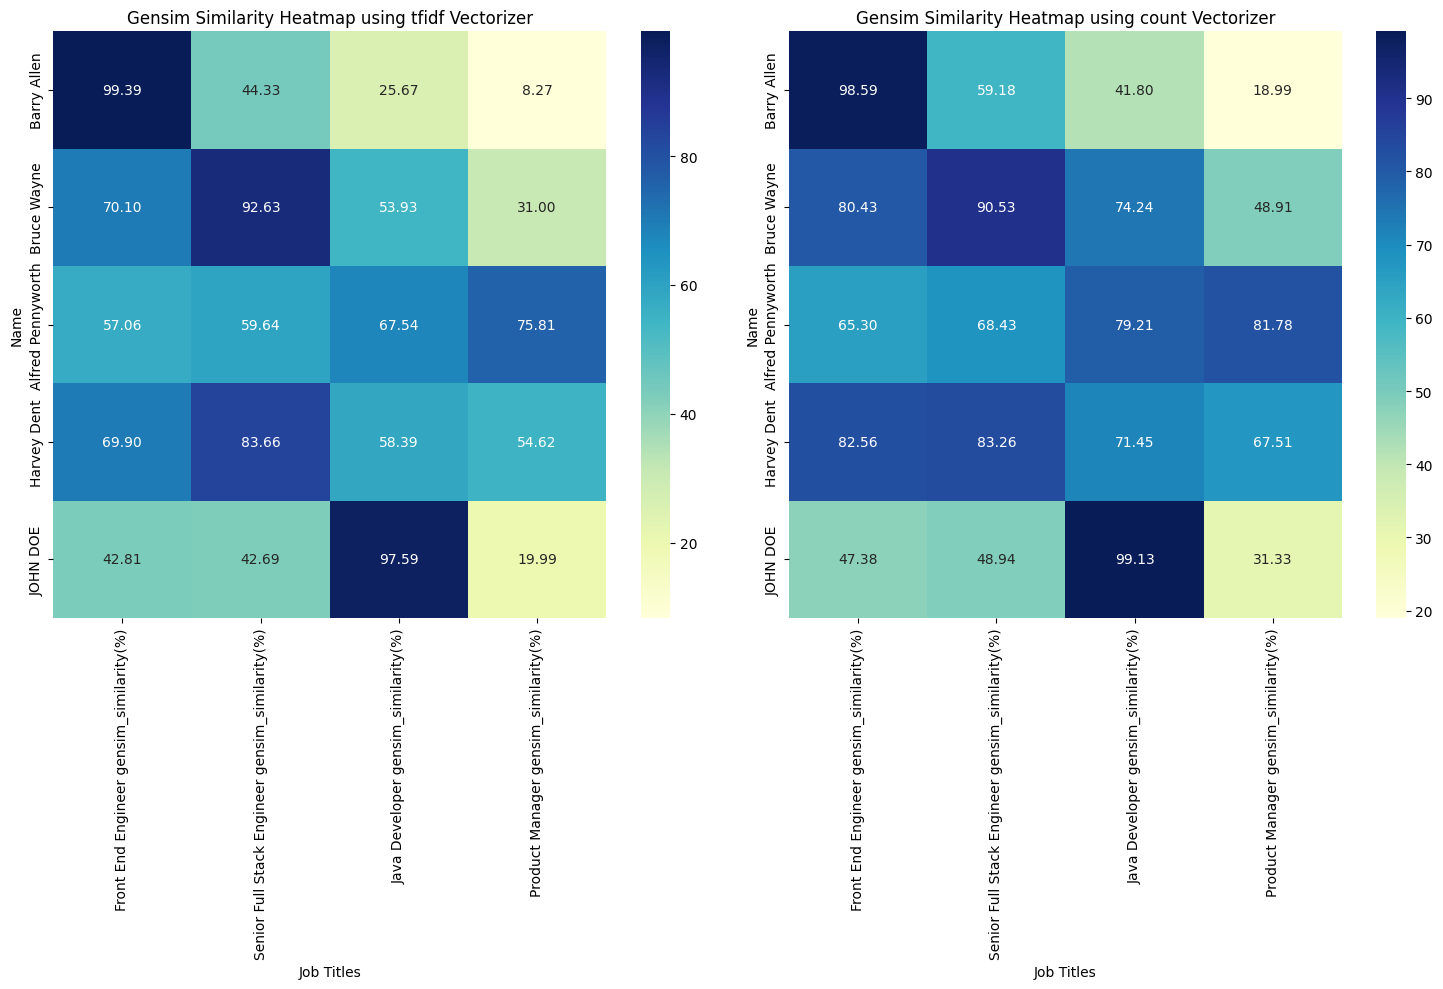

In [73]:
# Select only the columns with gensim_similarity
similarity_columns = [
    "Front End Engineer gensim_similarity(%)",
    "Senior Full Stack Engineer gensim_similarity(%)",
    "Java Developer gensim_similarity(%)",
    "Product Manager gensim_similarity(%)"
]

# Data
name = ['tfidf Vectorizer', 'count Vectorizer']
dataframes = [tfidf_result_gensim_1, count_vect_result_gensim_1]  # Assuming you have another DataFrame named count_result_gensim_1

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Iterate over dataframes and corresponding subplot axes
for ax, df, df_name in zip(axes, dataframes, name):
    # Copy DataFrame and set 'name' column as the index
    df_heat = df.copy()
    df_heat.set_index('name', inplace=True)

    # Create the heatmap
    heatmap = sns.heatmap(data=df_heat[similarity_columns], annot=True, cmap='YlGnBu', fmt='.2f', ax=ax)
    ax.set_xlabel("Job Titles")
    ax.set_ylabel("Name")
    ax.set_title("Gensim Similarity Heatmap using " + df_name)

# Adjust layout
plt.tight_layout()
plt.show()
